# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

Also tried: AdaBoost

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy', 'test_roc_auc', 'test_f1', 'test_average_precision'])
summary.index.name = 'method_name'

## Get the data

In [3]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [4]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [5]:
# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [6]:
# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

# get reduced dataset
impact = pd.concat([impact[impact.is_artefact],
                    impact[~impact.is_artefact].iloc[0:20000]], ignore_index=True)

# shuffle data
rng = np.random.RandomState(42)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]
impact.reset_index(drop=True, inplace=True)

# get features matrix X (n_samples x n_features) and target array y (n_samples)
X = impact.drop(label, axis=1)
y = impact[label]

print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
False,20000,73.5%
True,7199,26.5%


In [7]:
impact.head()

,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,sample_coverage,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,Kaviar_AF,is_artefact,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown
0,807,0.11276,91,312,0.0,0,824,0.0,0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,False,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0
1,584,0.05822,34,383,0.0,0,632,0.0,3,0.000012,0.0,0.00003,0.0,0.0,0.0,0.000018,0.0,0.000030,0.000014,0.000007,False,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0
2,673,0.51263,345,485,0.0,0,672,0.0,0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,False,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0
3,964,0.30498,294,371,0.0,0,669,0.0,14959,0.000004,0.0,0.00000,0.0,0.0,0.0,0.000009,0.0,0.000009,0.000005,0.000013,False,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0
4,366,0.36885,135,190,0.0,0,451,0.0,78,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000007,False,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [8]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Dummy

### Uniform

Generates predictions uniformly at random, expected accuracy: 0.5 | expected AUC: 0.5.

In [9]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform', random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (0.57s)
▴ Mean accuracy    : 0.499 ± 0.012
▴ Mean ROC AUC     : 0.500 ± 0.000
▴ Mean F1-score    : 0.343 ± 0.016
▴ Average precision: 0.265 ± 0.000


In [10]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.05s | 0.01s]
  → accuracy     : [0.494 | 0.503]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.337 | 0.350]
  → avg precision: [0.265 | 0.265]
Fold 2: [0.04s | 0.00s]
  → accuracy     : [0.502 | 0.501]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.348 | 0.348]
  → avg precision: [0.265 | 0.265]
Fold 3: [0.04s | 0.00s]
  → accuracy     : [0.508 | 0.498]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.355 | 0.344]
  → avg precision: [0.265 | 0.265]
Fold 4: [0.05s | 0.00s]
  → accuracy     : [0.495 | 0.499]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.339 | 0.346]
  → avg precision: [0.265 | 0.265]
Fold 5: [0.05s | 0.00s]
  → accuracy     : [0.494 | 0.500]
  → 

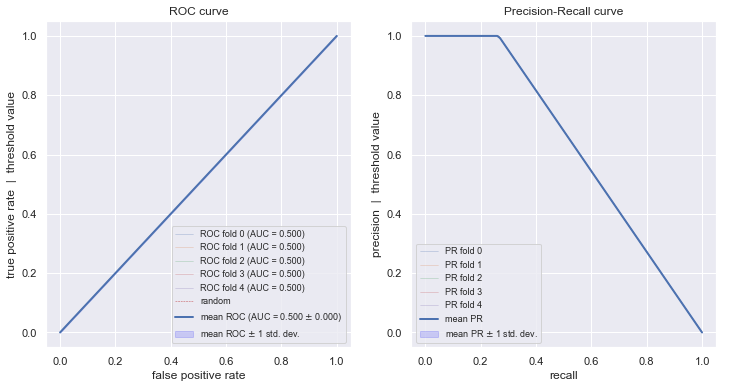

In [11]:
plot_roc_and_precision_recall(metrics, figsize=(12, 6), plot_thresholds=False)

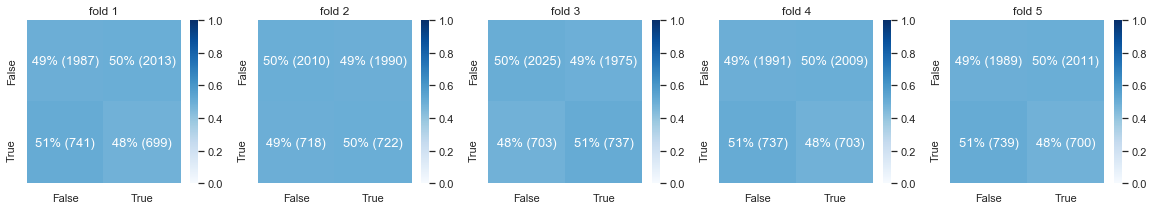

In [12]:
plot_confusion_matrix(metrics)

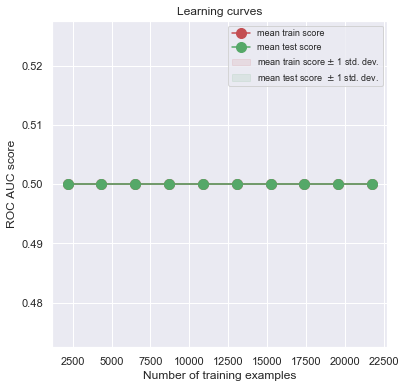

In [13]:
plot_learning_curves(model, X, y, cv_strategy, figsize=(6, 6))

In [14]:
metrics.columns

Index(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy',
       'test_roc_auc', 'train_roc_auc', 'test_f1', 'train_f1',
       'test_average_precision', 'train_average_precision', 'test_fpr',
       'test_tpr', 'roc_thresh', 'precision', 'recall', 'pr_thresh',
       'confusion_matrix'],
      dtype='object')

In [15]:
summary.loc['Uniform'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

### Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [16]:
model = DummyClassifier(strategy='most_frequent', random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-pac

 done! (0.58s)
▴ Mean accuracy    : 0.735 ± 0.000
▴ Mean ROC AUC     : 0.500 ± 0.000
▴ Mean F1-score    : 0.000 ± 0.000
▴ Average precision: 0.265 ± 0.000


In [17]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.05s | 0.01s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 2: [0.04s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 3: [0.04s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 4: [0.05s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 5: [0.04s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → 

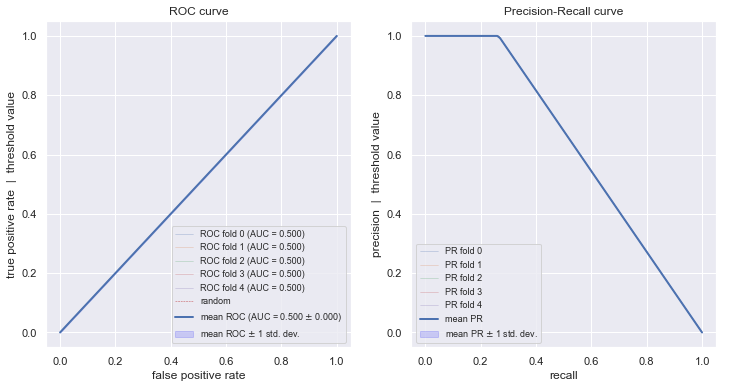

In [18]:
plot_roc_and_precision_recall(metrics, figsize=(12, 6), plot_thresholds=False)

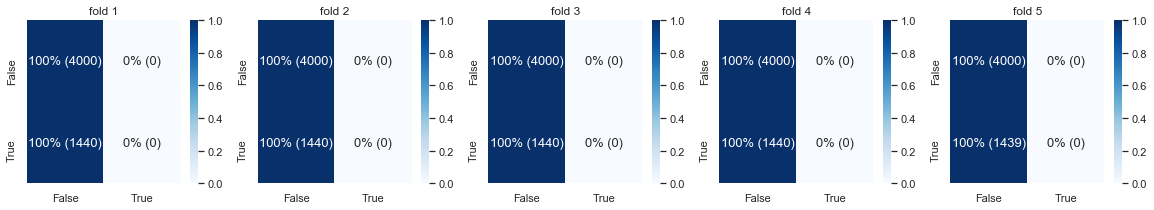

In [19]:
plot_confusion_matrix(metrics)

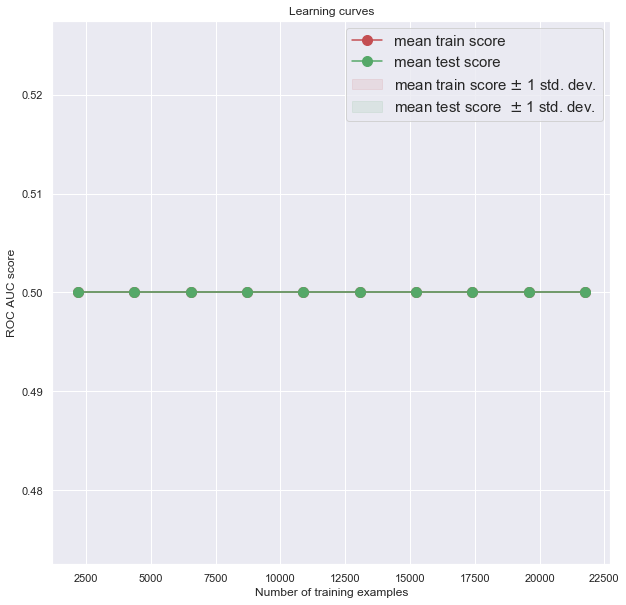

In [20]:
plot_learning_curves(model, X, y, cv_strategy)

In [21]:
summary.loc['MostFrequent'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Gaussian Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (1.32s)
▴ Mean accuracy    : 0.811 ± 0.009
▴ Mean ROC AUC     : 0.834 ± 0.009
▴ Mean F1-score    : 0.555 ± 0.018
▴ Average precision: 0.688 ± 0.032


In [23]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.08s | 0.02s]
  → accuracy     : [0.814 | 0.810]
  → ROC AUC      : [0.838 | 0.833]
  → F1-score     : [0.556 | 0.552]
  → avg precision: [0.698 | 0.685]
Fold 2: [0.07s | 0.03s]
  → accuracy     : [0.815 | 0.813]
  → ROC AUC      : [0.835 | 0.835]
  → F1-score     : [0.565 | 0.555]
  → avg precision: [0.700 | 0.689]
Fold 3: [0.07s | 0.03s]
  → accuracy     : [0.815 | 0.814]
  → ROC AUC      : [0.838 | 0.836]
  → F1-score     : [0.561 | 0.559]
  → avg precision: [0.700 | 0.691]
Fold 4: [0.14s | 0.02s]
  → accuracy     : [0.804 | 0.813]
  → ROC AUC      : [0.826 | 0.836]
  → F1-score     : [0.542 | 0.568]
  → avg precision: [0.662 | 0.695]
Fold 5: [0.08s | 0.03s]
  → accuracy     : [0.808 | 0.813]
  → 

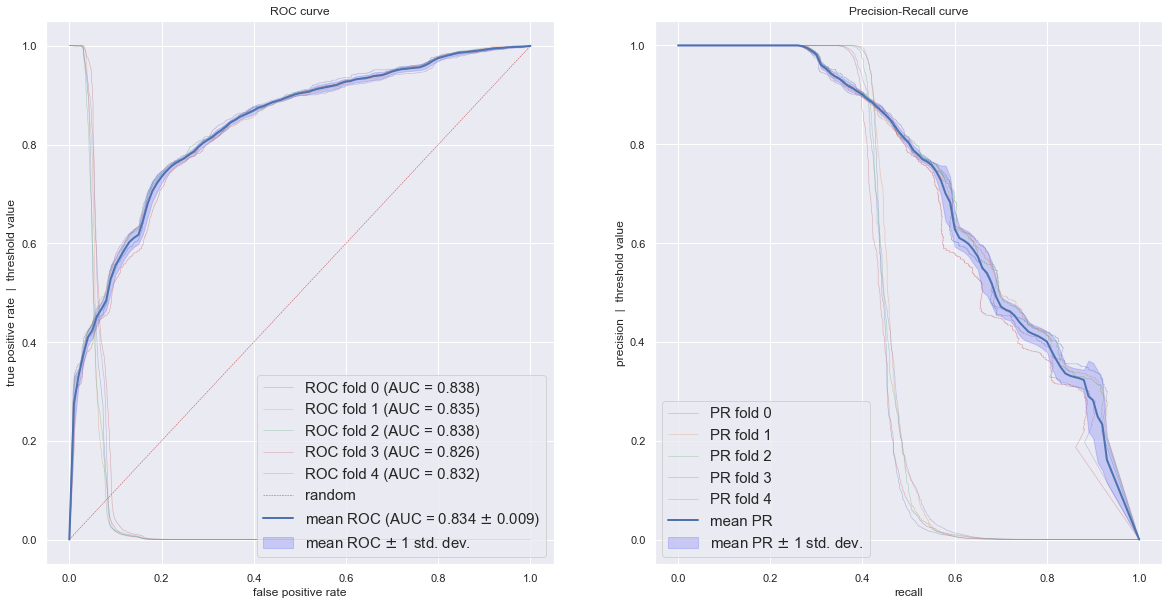

In [24]:
plot_roc_and_precision_recall(metrics)

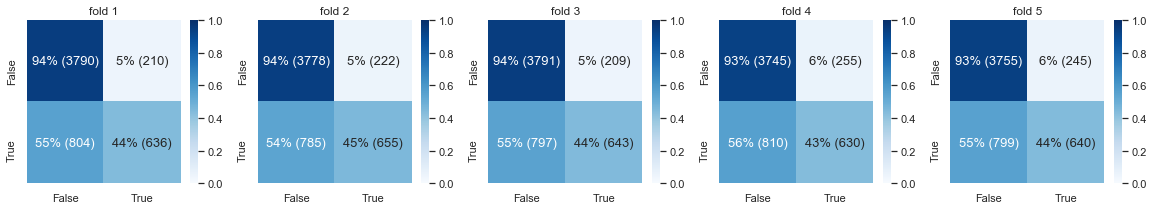

In [25]:
plot_confusion_matrix(metrics)

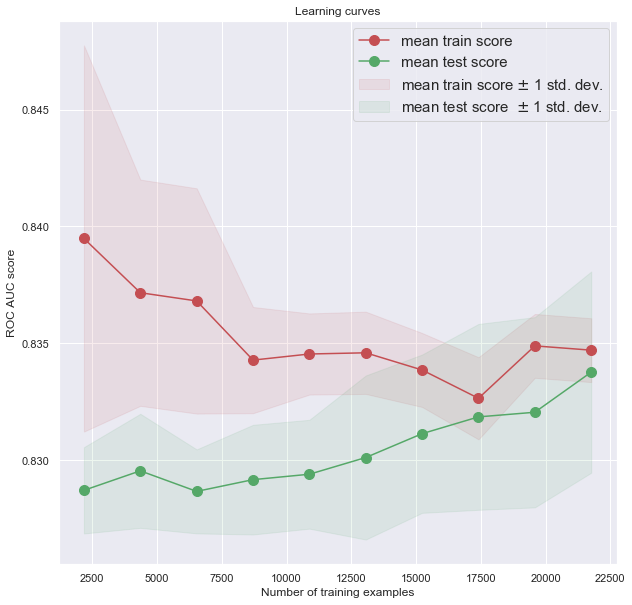

In [26]:
plot_learning_curves(model, X, y, cv_strategy)

In [27]:
summary.loc['GausssianNaiveBayes'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Logistic Regression

### Ridge regression (L2 regularization)

#### Run the model

This model performs an automatic grid search over its parameters.

In [28]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', max_iter=3000, n_jobs=-1, random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


 done! (43.40s)
▴ Mean accuracy    : 0.866 ± 0.010
▴ Mean ROC AUC     : 0.885 ± 0.012
▴ Mean F1-score    : 0.703 ± 0.025
▴ Average precision: 0.809 ± 0.025


In [29]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [8.85s | 0.01s]
  → accuracy     : [0.870 | 0.866]
  → ROC AUC      : [0.888 | 0.883]
  → F1-score     : [0.714 | 0.706]
  → avg precision: [0.816 | 0.807]
Fold 2: [6.43s | 0.01s]
  → accuracy     : [0.859 | 0.864]
  → ROC AUC      : [0.875 | 0.884]
  → F1-score     : [0.685 | 0.698]
  → avg precision: [0.794 | 0.805]
Fold 3: [10.05s | 0.01s]
  → accuracy     : [0.871 | 0.869]
  → ROC AUC      : [0.888 | 0.888]
  → F1-score     : [0.712 | 0.710]
  → avg precision: [0.819 | 0.819]
Fold 4: [8.10s | 0.01s]
  → accuracy     : [0.862 | 0.868]
  → ROC AUC      : [0.881 | 0.887]
  → F1-score     : [0.695 | 0.709]
  → avg precision: [0.797 | 0.814]
Fold 5: [9.34s | 0.01s]
  → accuracy     : [0.868 | 0.866]
  →

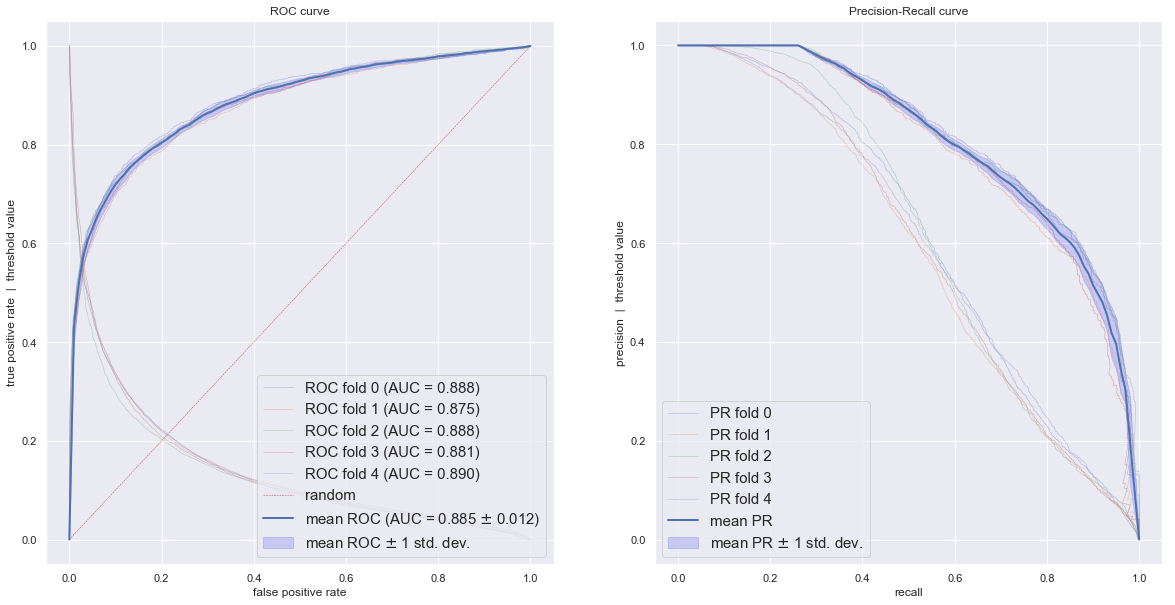

In [30]:
plot_roc_and_precision_recall(metrics)

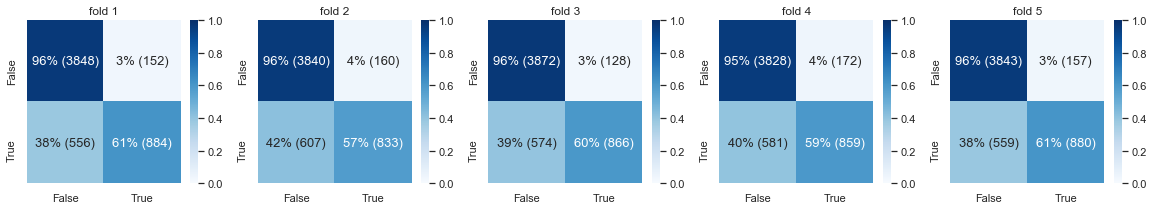

In [31]:
plot_confusion_matrix(metrics)

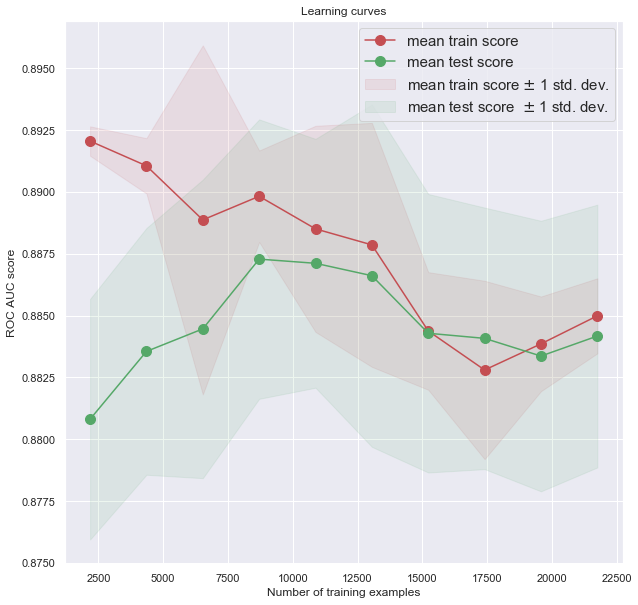

In [32]:
plot_learning_curves(model, X, y, cv_strategy)

In [33]:
summary.loc['RidgeRegression'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

#### Study coefficients

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

scaler = StandardScaler()
model = LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', max_iter=3000, n_jobs=-1, random_state=42)

model.fit(scaler.fit_transform(X), y);

"If your variables are positively correlated, then the coefficients will be negatively correlated, which can lead to a wrong sign on one of the coefficients.", see https://stats.stackexchange.com/questions/1580/regression-coefficients-that-flip-sign-after-including-other-predictors.

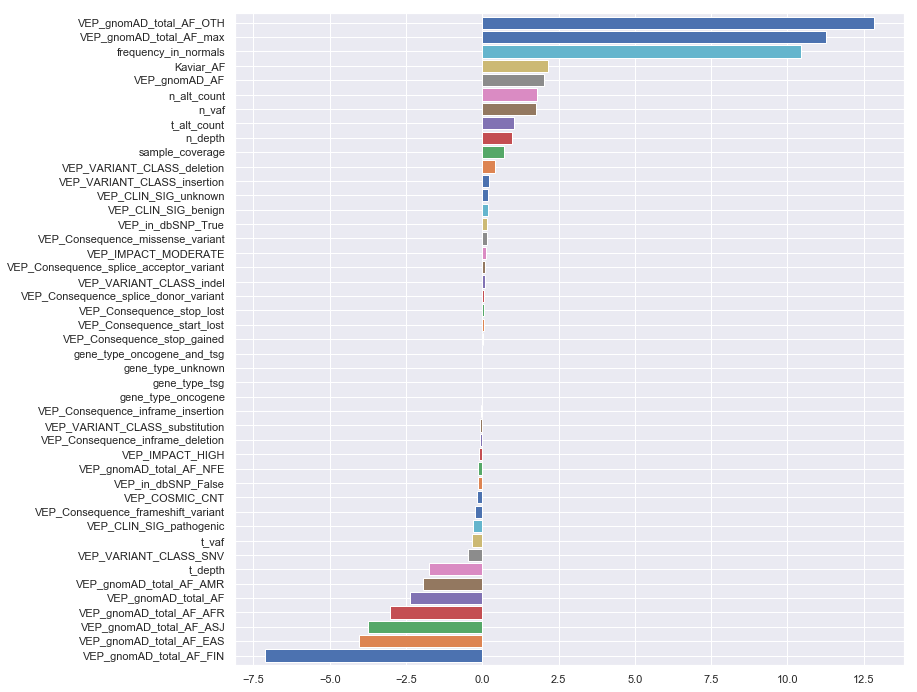

In [35]:
feature_coefficient = pd.DataFrame({'coeff': model.coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85);

### Lasso regression (L1 regularization)

#### Run the model

In [36]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', n_jobs=-1, random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (28.88s)
▴ Mean accuracy    : 0.880 ± 0.004
▴ Mean ROC AUC     : 0.898 ± 0.009
▴ Mean F1-score    : 0.729 ± 0.012
▴ Average precision: 0.844 ± 0.015


In [37]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [6.72s | 0.03s]
  → accuracy     : [0.883 | 0.880]
  → ROC AUC      : [0.904 | 0.897]
  → F1-score     : [0.739 | 0.729]
  → avg precision: [0.853 | 0.843]
Fold 2: [5.77s | 0.02s]
  → accuracy     : [0.878 | 0.880]
  → ROC AUC      : [0.894 | 0.900]
  → F1-score     : [0.723 | 0.731]
  → avg precision: [0.838 | 0.848]
Fold 3: [5.44s | 0.02s]
  → accuracy     : [0.881 | 0.880]
  → ROC AUC      : [0.898 | 0.899]
  → F1-score     : [0.728 | 0.729]
  → avg precision: [0.843 | 0.845]
Fold 4: [5.17s | 0.02s]
  → accuracy     : [0.878 | 0.882]
  → ROC AUC      : [0.894 | 0.901]
  → F1-score     : [0.727 | 0.734]
  → avg precision: [0.835 | 0.849]
Fold 5: [5.00s | 0.02s]
  → accuracy     : [0.880 | 0.880]
  → 

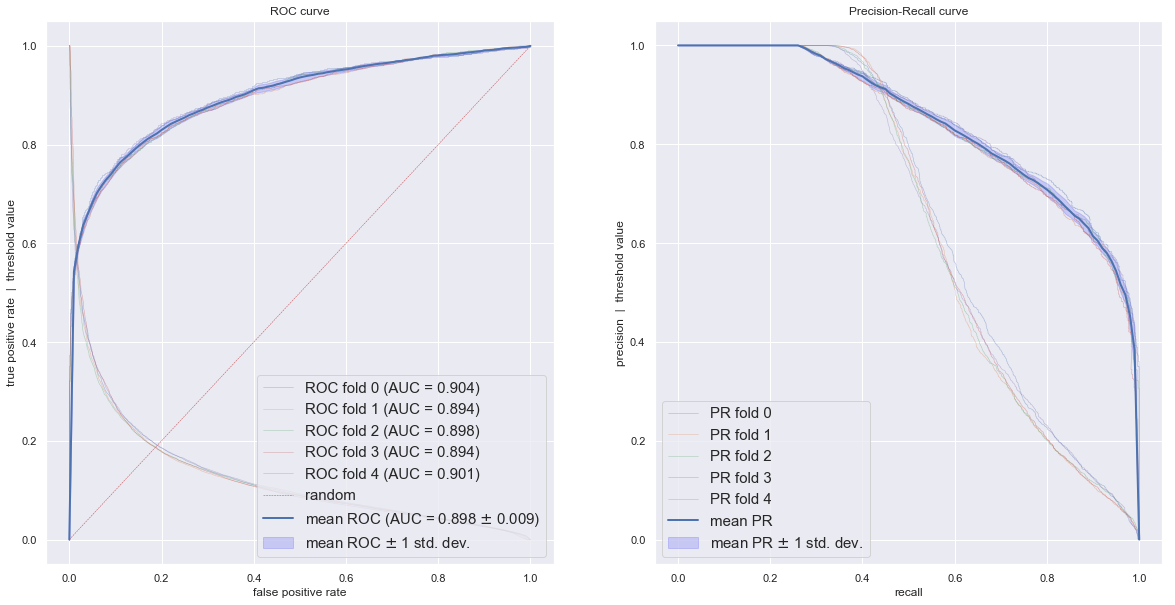

In [38]:
plot_roc_and_precision_recall(metrics)

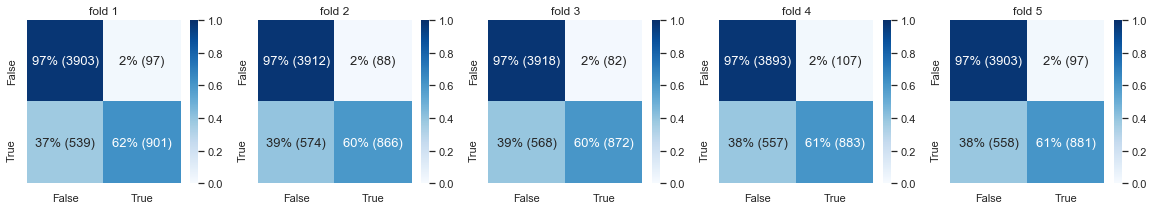

In [39]:
plot_confusion_matrix(metrics)

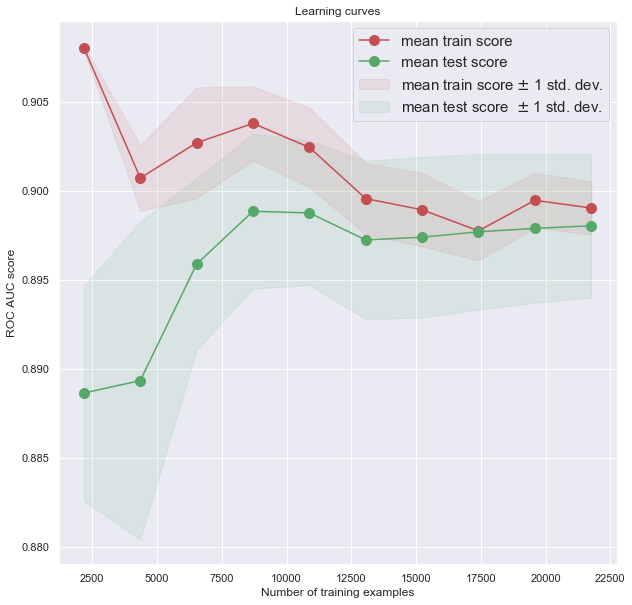

In [40]:
plot_learning_curves(model, X, y, cv_strategy)

In [41]:
summary.loc['LassoRegression'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

#### Study coefficients

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

scaler = StandardScaler()
model = LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', n_jobs=-1, random_state=42)

model.fit(scaler.fit_transform(X), y);

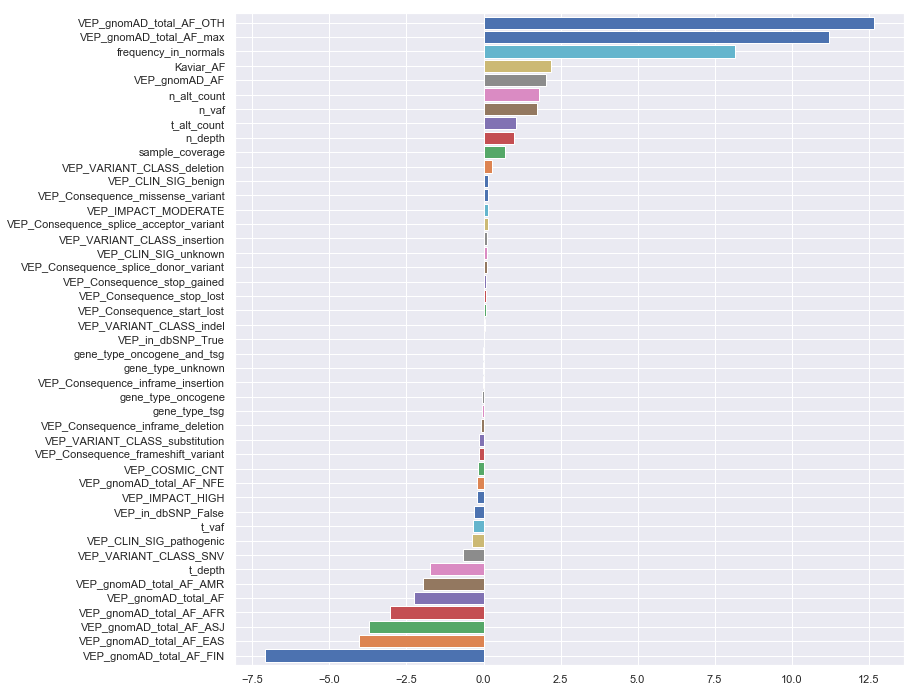

In [43]:
feature_coefficient = pd.DataFrame({'coeff': model.coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85);

## K Nearest Neighbors

In [68]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < kNN >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [69]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

In [70]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_kNN


<span style="color:green">Job < kNN >: </span>✅ data loaded

In [71]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
parameters_grid = [
    {'classify__n_neighbors': [5, 10, 20, 25, 30, 40, 50, 60, 100], 'classify__weights': ['uniform', 'distance']}
]
pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_kNN/script.ipy


In [72]:
job.run(n_jobs=5, short_job=False)

➞ scp ../ssh_remote_jobs/job_kNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100%  310KB 308.6KB/s   00:01    
metrics.pkl                                   100%  601KB   9.2MB/s   00:00    
script.ipy                                    100% 1080   125.9KB/s   00:00    
X.pkl                                         100% 5053KB  15.2MB/s   00:00    
y.pkl                                         100%   27KB   2.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_kNN
Job <28479707> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < kNN >: </span>✅ submitted<br>

In [133]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

<span style="color:green">Job < kNN >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_kNN to ../ssh_remote_jobs/job_kNN
metrics.pkl                                   100%  601KB   3.9MB/s   00:00    
job_output.txt                                100%  309KB   2.6MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.878 ± 0.005
▴ Mean ROC AUC     : 0.909 ± 0.008
▴ Mean F1-score    : 0.723 ± 0.013
▴ Average precision: 0.848 ± 0.009


In [134]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [1888.20s | 197.41s]
  → accuracy     : [0.875 | 1.000]
  → ROC AUC      : [0.911 | 1.000]
  → F1-score     : [0.716 | 1.000]
  → avg precision: [0.849 | 1.000]
  → best hyperparameters: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
Fold 2: [1885.89s | 38.57s]
  → accuracy     : [0.879 | 1.000]
  → ROC AUC      : [0.903 | 1.000]
  → F1-score     : [0.727 | 1.000]
  → avg precision: [0.846 | 1.000]
  → best hyperparameters: {'classify__n_neighbors': 25, 'classify__weights': 'distance'}
Fold 3: [2383.48s | 43.62s]
  → accuracy     : [0.880 | 1.000]
  → ROC AUC      : [0.912 | 1.000]
  → F1-score     : [0.726 | 1.000

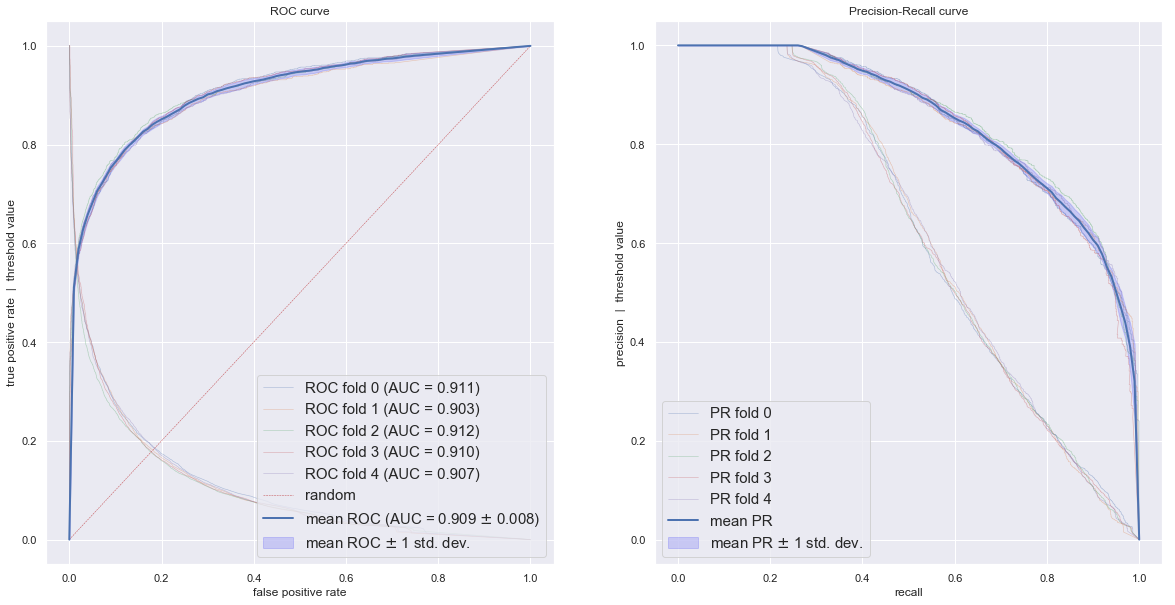

In [135]:
plot_roc_and_precision_recall(job.metrics)

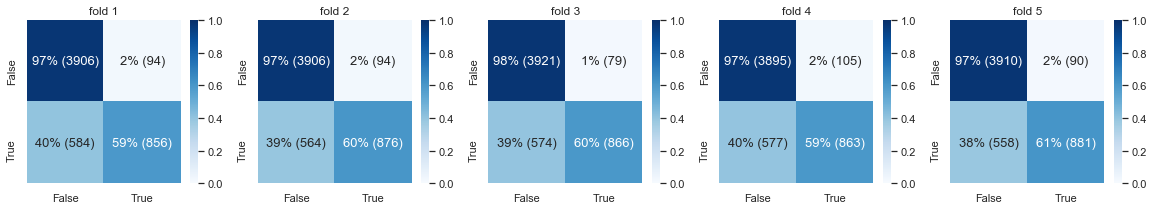

In [136]:
plot_confusion_matrix(job.metrics)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__n_neighbors: [5 10 20 25 30 40 50 60 100]
  → classify__weights    : ['distance' 'uniform']
Best hyperparameters for each fold:
fold 0: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
fold 1: {'classify__n_neighbors': 25, 'classify__weights': 'distance'}
fold 2: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
fold 3: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
fold 4: {'classify__n_neighbors': 25, 'classify__weights': 'distance'}


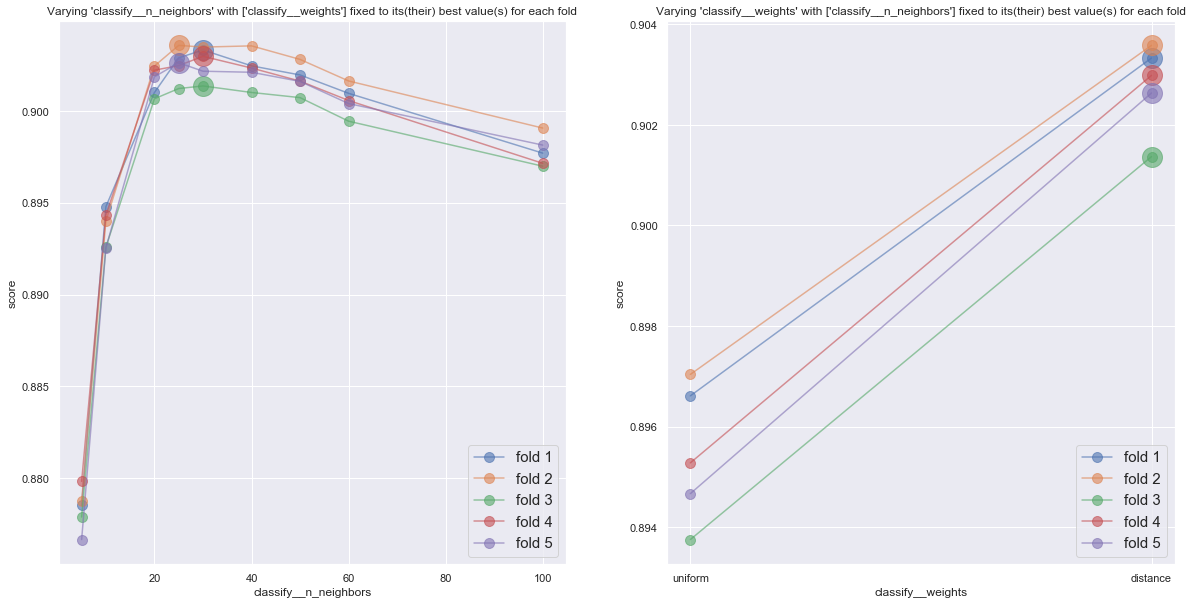

In [137]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [138]:
summary.loc['kNN'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Random Forest

### Create job

In [74]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < RandomForest >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [75]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < RandomForest >: </span>✅ job found and reloaded

In [76]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest


<span style="color:green">Job < RandomForest >: </span>✅ data loaded

In [77]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, 100, 200]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_RandomForest/script.ipy


In [78]:
job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ../ssh_remote_jobs/job_RandomForest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1515     1.5KB/s   00:01    
metrics.pkl                                   100%  692KB   7.8MB/s   00:00    
script.ipy                                    100%  934     0.9KB/s   00:01    
X.pkl                                         100% 5053KB  13.0MB/s   00:00    
y.pkl                                         100%   27KB  64.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest
Job <28479739> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest >: </span>✅ submitted<br>

In [139]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < RandomForest >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest to ../ssh_remote_jobs/job_RandomForest
metrics.pkl                                   100%  692KB   4.2MB/s   00:00    
job_output.txt                                100% 1515    73.1KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.904 ± 0.010
▴ Mean ROC AUC     : 0.938 ± 0.005
▴ Mean F1-score    : 0.798 ± 0.020
▴ Average precision: 0.897 ± 0.009


In [140]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [1493.43s | 9.13s]
  → accuracy     : [0.905 | 0.989]
  → ROC AUC      : [0.940 | 1.000]
  → F1-score     : [0.801 | 0.979]
  → avg precision: [0.899 | 1.000]
  → best hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
Fold 2: [1529.63s | 4.73s]
  → accuracy     : [0.906 | 0.991]
  → ROC AUC      : [0.937 | 1.000]
  → F1-score     : [0.800 | 0.982]
  → avg precision: [0.897 | 1.000]
  → best hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
Fold 3: [1499.32s | 10.03s]
  → accuracy     : [0.912 | 0.989]
  → ROC AUC      : [0.941 | 1.000]
  → F1-score     : [0.813 | 0.978]

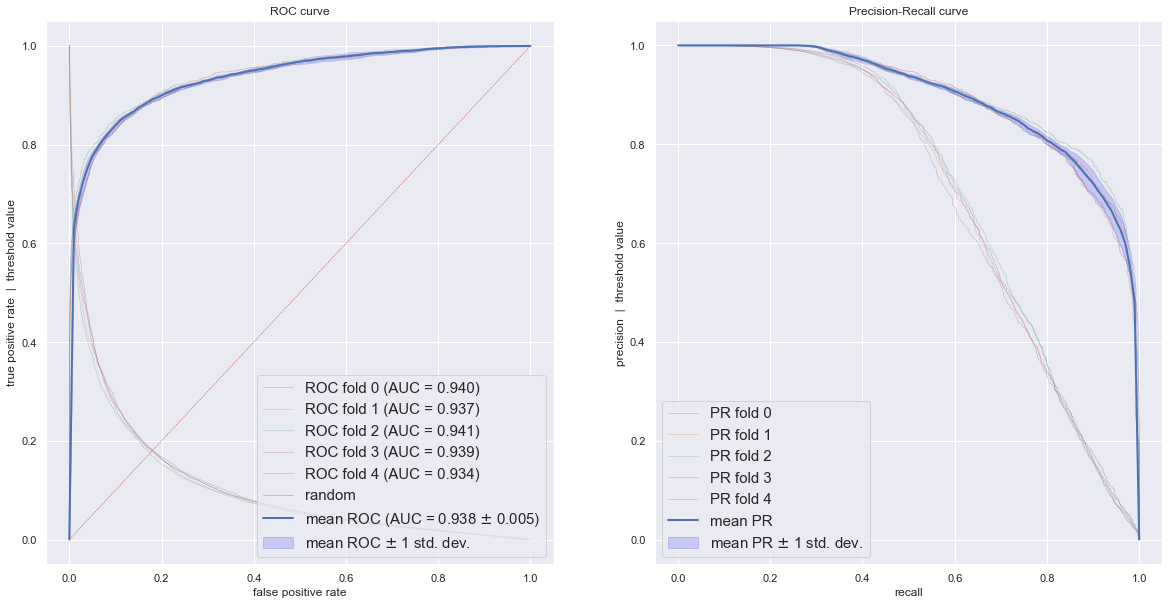

In [141]:
plot_roc_and_precision_recall(job.metrics)

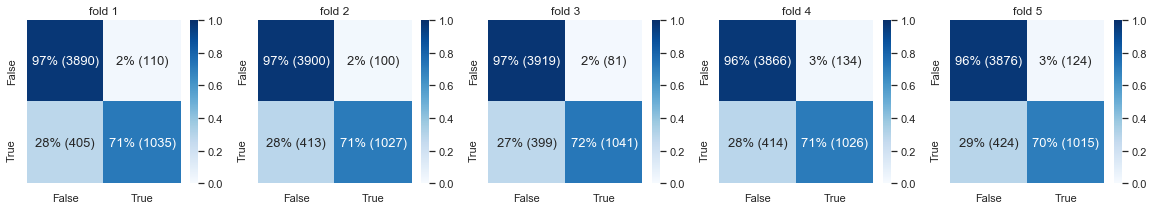

In [142]:
plot_confusion_matrix(job.metrics)

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100 200]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}


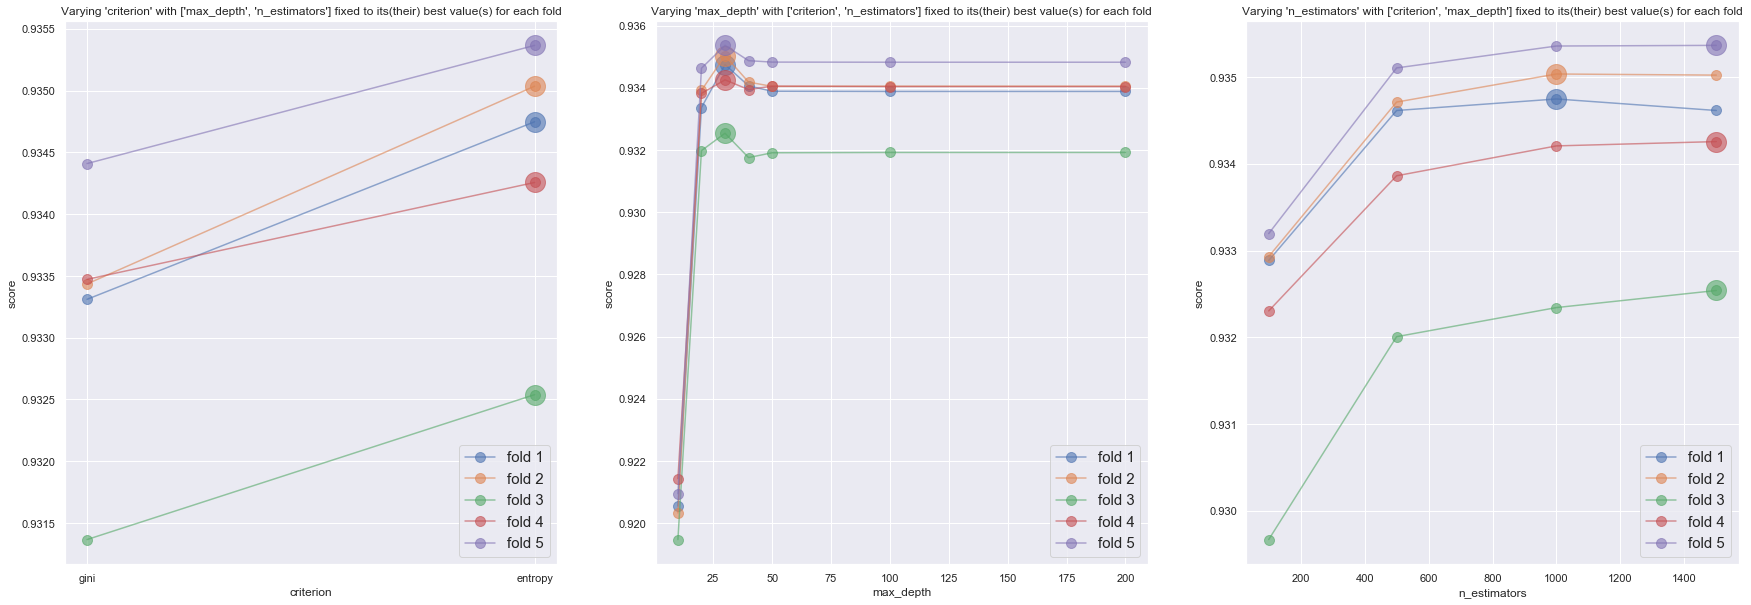

In [143]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [144]:
summary.loc['RandomForest'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [80]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy')
model_best_RandomForestClassifier.fit(X, y);

This is *gini importance* (and not the mean decrease accuracy), see https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined>

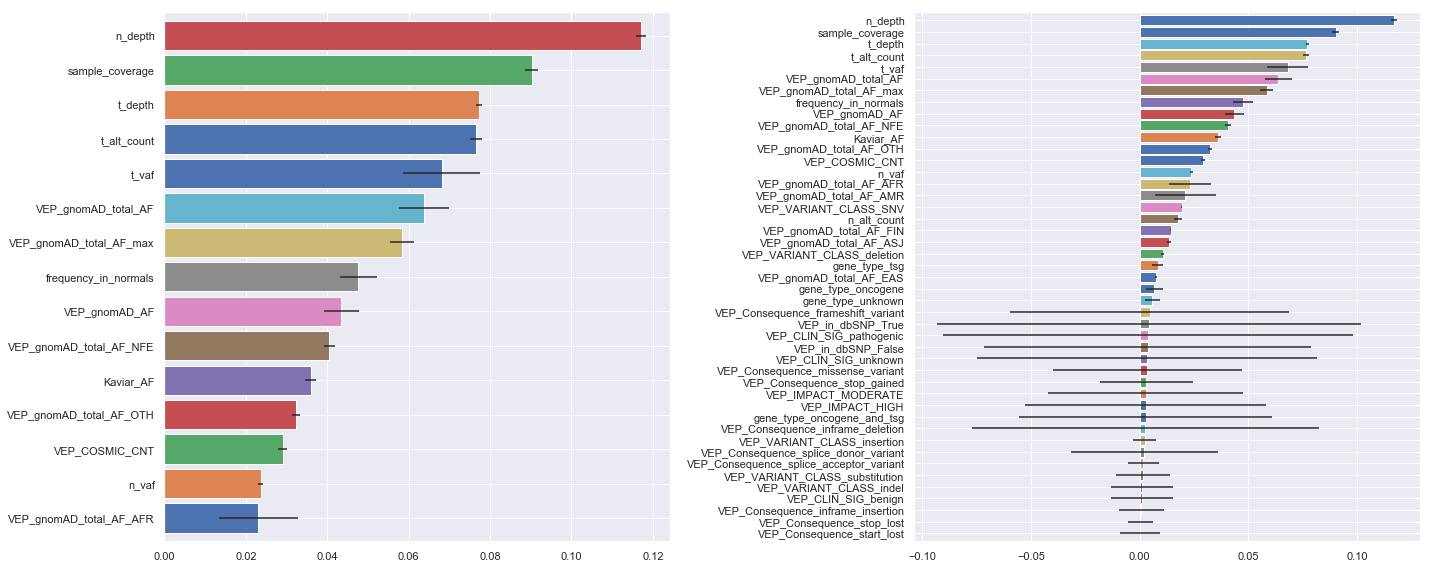

In [81]:
feature_importance = pd.DataFrame({'value': model_best_RandomForestClassifier.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_best_RandomForestClassifier.estimators_], axis=0)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
plt.tight_layout()

## Gradient Boosting

### Create job

In [82]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < GradientBoosting >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [83]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < GradientBoosting >: </span>✅ job found and reloaded

In [84]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_GradientBoosting


<span style="color:green">Job < GradientBoosting >: </span>✅ data loaded

In [85]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2], 'n_estimators': [100, 500, 1000, 1500, 2000], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 20]}
]
model = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_GradientBoosting/script.ipy


In [86]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ../ssh_remote_jobs/job_GradientBoosting to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1404     0.7KB/s   00:02    
metrics.pkl                                   100%  463KB   5.7MB/s   00:00    
script.ipy                                    100% 1006    40.9KB/s   00:00    
X.pkl                                         100% 5053KB  11.2MB/s   00:00    
y.pkl                                         100%   27KB   1.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_GradientBoosting
Job <28479832> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < GradientBoosting >: </span>✅ submitted<br>

In [87]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < GradientBoosting >: </span>✅ job found and reloaded

<span style="color:red">Job < GradientBoosting >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [4]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [185158.37s | 0.56s]
  → accuracy: [0.919 | 1.000]
  → ROC AUC : [0.951 | 1.000]
  → best hyperparameters: {'learning_rate': 0.11, 'loss': 'exponential', 'max_depth': 10, 'n_estimators': 1000}
Fold 2: [183836.36s | 1.45s]
  → accuracy: [0.914 | 1.000]
  → ROC AUC : [0.947 | 1.000]
  → best hyperparameters: {'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
Fold 3: [185037.77s | 0.57s]
  → accuracy: [0.923 | 1.000]
  → ROC AUC : [0.949 | 1.000]
  → best hyperparameters: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
Fold 4: [174160.96s | 1.53s]
  → accuracy: [0.911 | 1.000]
  → ROC AUC : [0.948 | 1.000]
  → best hyperparameters: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
Fold 

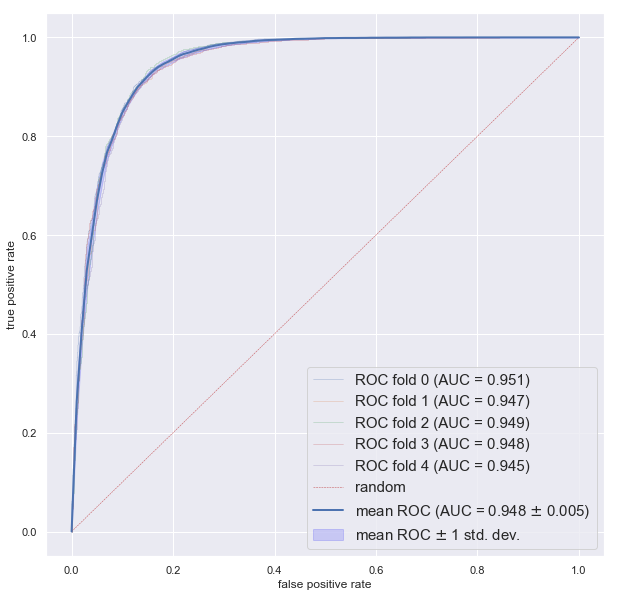

In [5]:
plot_roc_and_precision_recall(job.metrics)

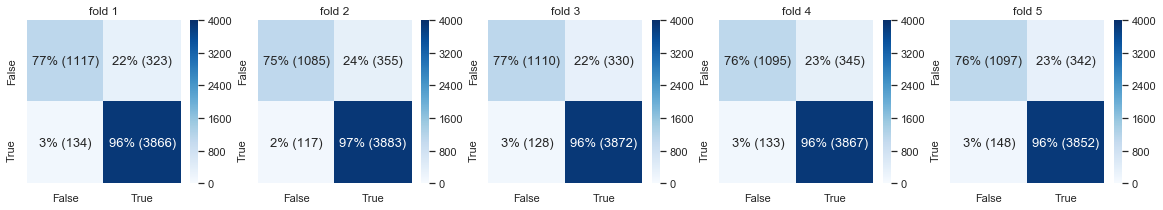

In [34]:
plot_confusion_matrix(job.metrics)

4 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → learning_rate: [0.05 0.08 0.09 0.1 0.11 0.12 0.2]
  → loss         : ['deviance' 'exponential']
  → max_depth    : [10 20 30 40 50 100 200]
  → n_estimators : [100 500 1000 1500 2000]
Best hyperparameters for each fold:
fold 0: {'learning_rate': 0.11, 'loss': 'exponential', 'max_depth': 10, 'n_estimators': 1000}
fold 1: {'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
fold 2: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
fold 3: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
fold 4: {'learning_rate': 0.11, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}


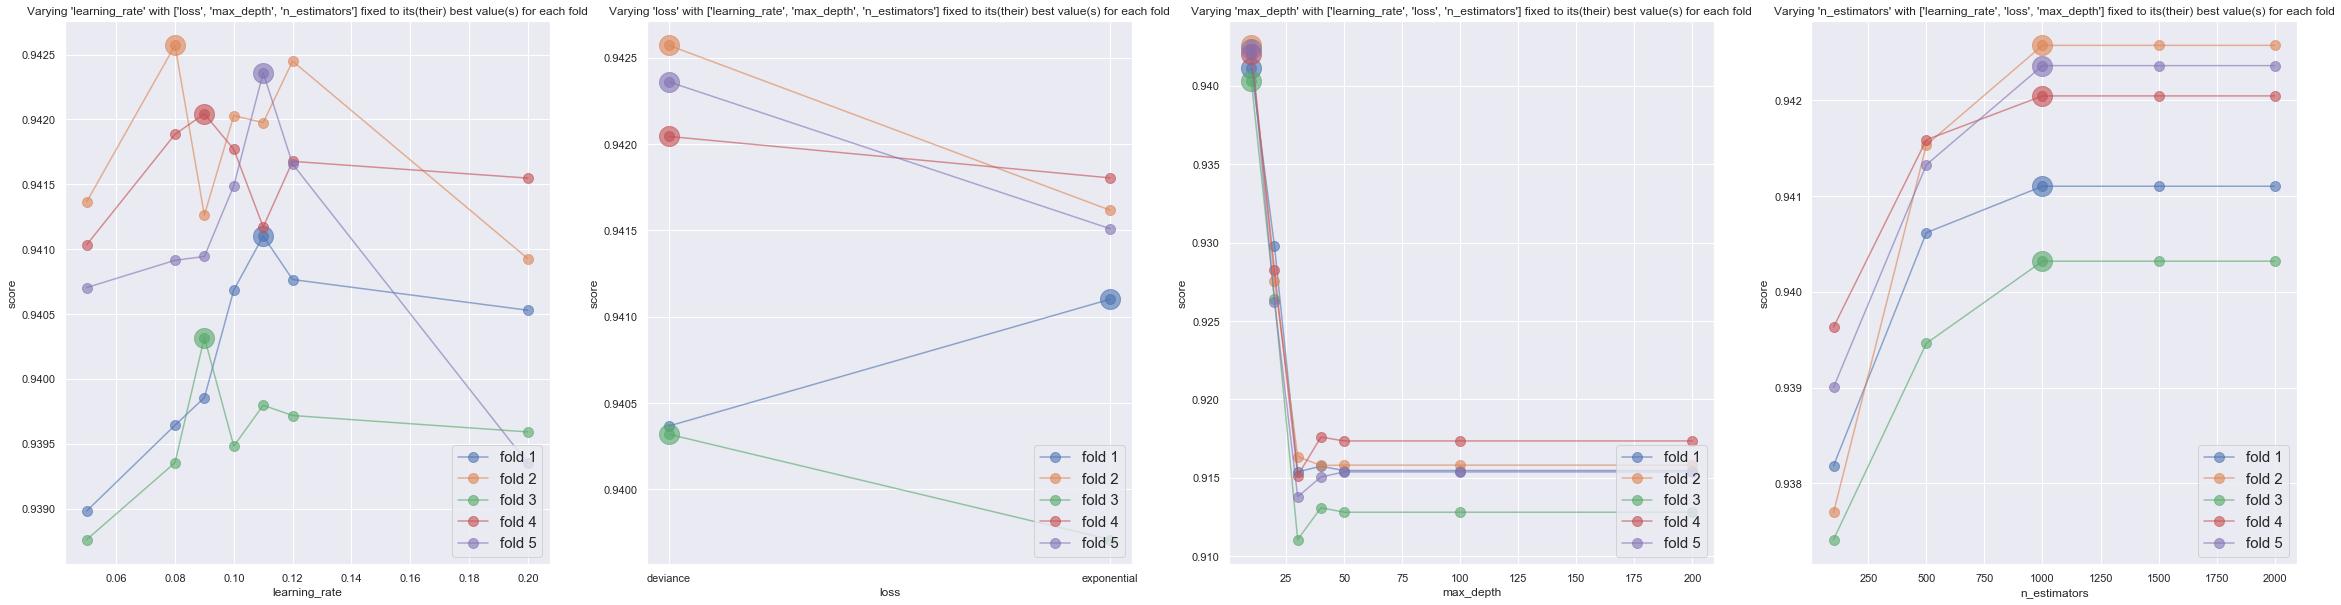

In [6]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [ ]:
summary.loc['GradientBoosting'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=1000, max_depth=10, loss='deviance')
model_best_GradientBoostingClassifier.fit(X, y);

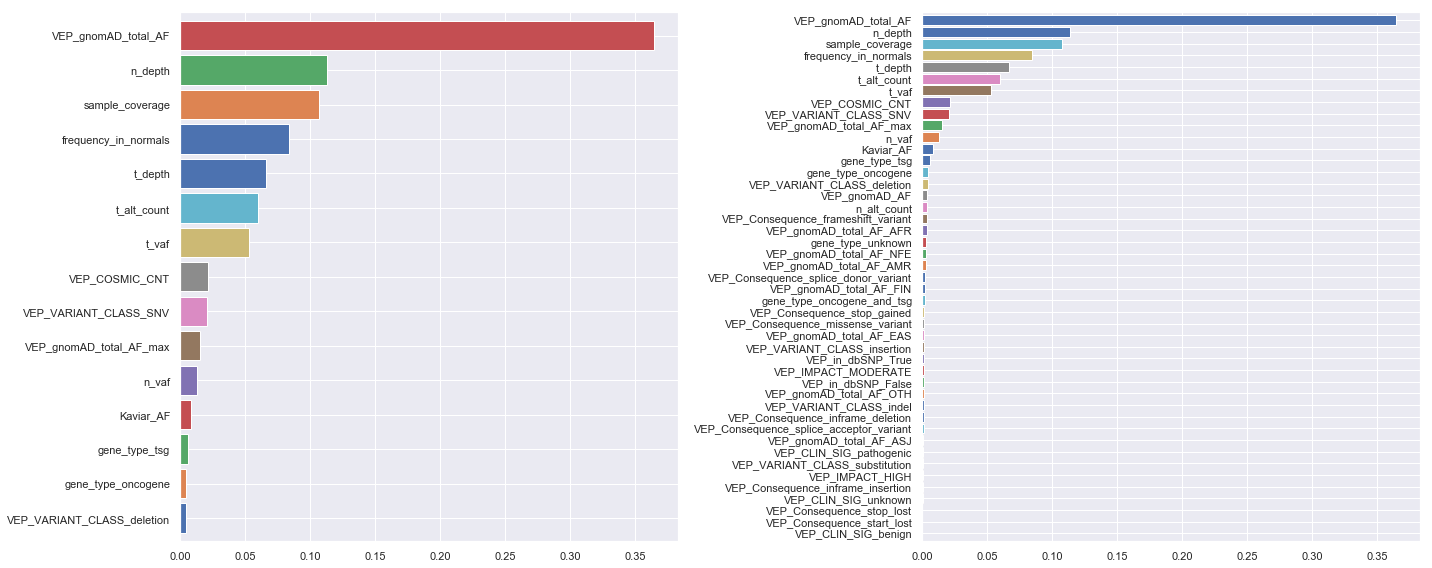

In [89]:
feature_importance = pd.DataFrame({'value': model_best_GradientBoostingClassifier.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85)
plt.tight_layout()

## Support Vector Machine

In [90]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < SVM >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [166]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

In [167]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_SVM


<span style="color:green">Job < SVM >: </span>✅ data loaded

In [168]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
parameters_grid = [
    {'classify__C': [0.1, 0.8, 0.9, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'classify__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
]
pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', SVC(probability=True, cache_size=1000, gamma='scale'))])
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_SVM/script.ipy


In [169]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ../ssh_remote_jobs/job_SVM to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100%  281KB   1.1MB/s   00:00    
metrics.pkl                                   100%  766KB   9.9MB/s   00:00    
script.ipy                                    100% 1102     6.8KB/s   00:00    
X.pkl                                         100% 5053KB  16.0MB/s   00:00    
y.pkl                                         100%   27KB   2.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_SVM
Job <28482671> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < SVM >: </span>✅ submitted<br>

In [170]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

<span style="color:red">Job < SVM >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [160]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [4294.37s | 11.38s]
  → accuracy     : [0.882 | 0.882]
  → ROC AUC      : [0.913 | 0.917]
  → F1-score     : [0.728 | 0.729]
  → avg precision: [0.862 | 0.867]
  → best hyperparameters: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
Fold 2: [4161.06s | 11.13s]
  → accuracy     : [0.877 | 0.881]
  → ROC AUC      : [0.912 | 0.917]
  → F1-score     : [0.717 | 0.727]
  → avg precision: [0.856 | 0.866]
  → best hyperparameters: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
Fold 3: [3625.20s | 11.11s]
  → accuracy     : [0.879 | 0.881]
  → ROC AUC      : [0.908 | 0.917]
  → F1-score     : [0.717 | 0.727]
  → avg precision: [0.855 | 0

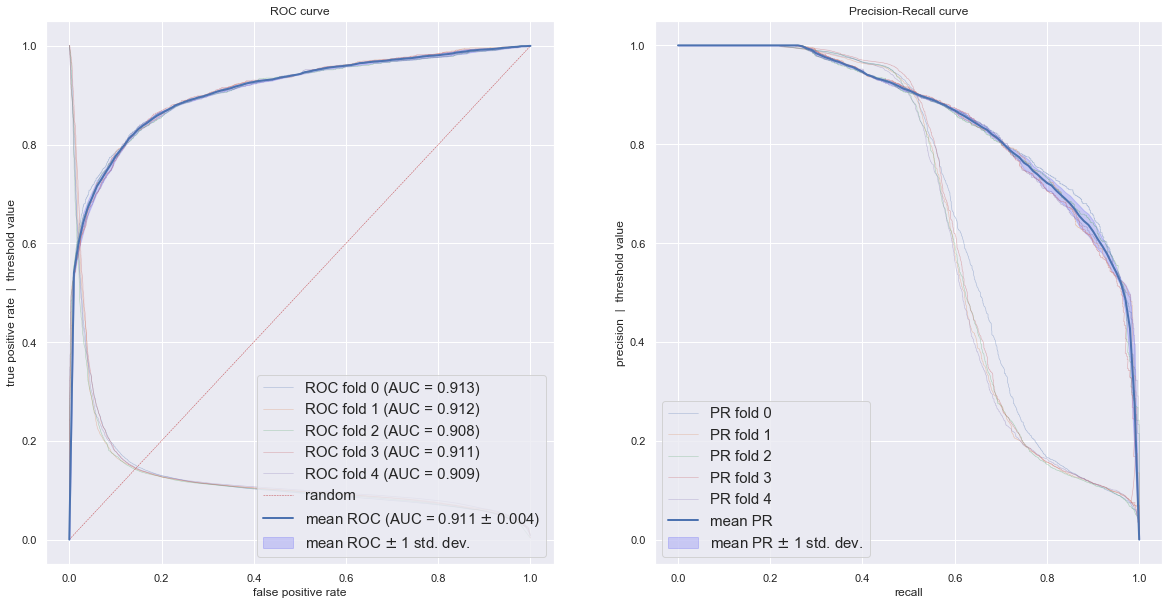

In [161]:
plot_roc_and_precision_recall(job.metrics)

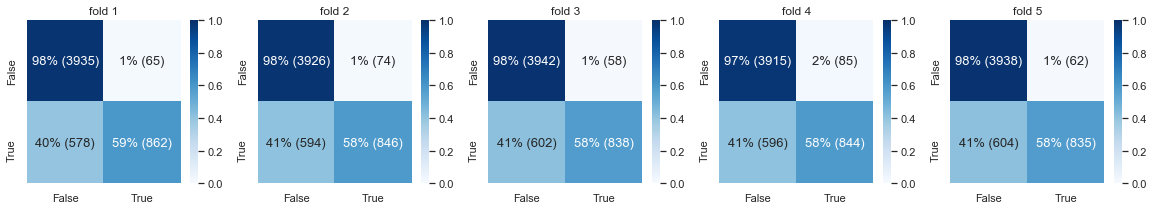

In [162]:
plot_confusion_matrix(job.metrics)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__C     : [0.01 0.1 1.0 10.0]
  → classify__kernel: ['linear' 'poly' 'rbf' 'sigmoid']
Best hyperparameters for each fold:
fold 0: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
fold 1: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
fold 2: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
fold 3: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
fold 4: {'classify__C': 1.0, 'classify__kernel': 'rbf'}


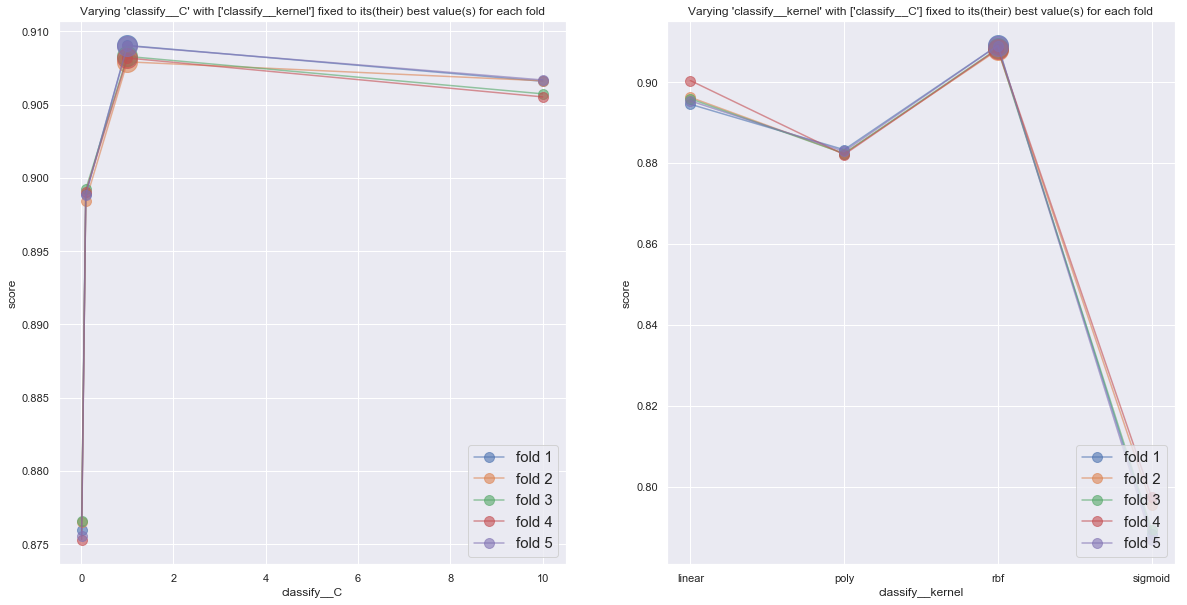

In [163]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [164]:
summary.loc['SVM'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Summary

In [172]:
summary = pd.read_pickle('summary.pkl')

In [173]:
summary.style.highlight_max(axis=0, color='yellow').set_precision(3)

,test_accuracy,test_roc_auc,test_f1,test_average_precision
method_name,,,,
Uniform,0.499,0.5,0.343,0.265
MostFrequent,0.735,0.5,0,0.265
GausssianNaiveBayes,0.811,0.834,0.555,0.688
RidgeRegression,0.866,0.885,0.703,0.809
LassoRegression,0.88,0.898,0.729,0.844
kNN,0.878,0.909,0.723,0.848
RandomForest,0.904,0.938,0.798,0.897
SVM,0.878,0.911,0.718,0.856


In [171]:
summary.to_pickle('summary.pkl')